In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import pandas

data = pandas.read_csv("/content/drive/Othercomputers/내 노트북/File/spamVenv/files/spam.csv", encoding="UTF-8").dropna(axis=0)


originData = data[["Subject", "Spam/Ham"]].rename(columns={"Spam/Ham":"isSpam", "Subject":"content"}).drop_duplicates() #제목, 스팸여부 & 중복제거(결측치)
originData["isSpam"] = originData['isSpam'].replace(["ham", "spam"], [0, 1]) #범주형 -> 수치형


# # data["isSpam"].value_counts() #스팸 비율
# # print(f'스팸 : 정상 비율 : {data["isSpam"].value_counts()[0]/data["isSpam"].size} : {data["isSpam"].value_counts()[1]/data["isSpam"].size}')

_index = originData['content'].apply(lambda x: isinstance(x, (int, float))).index[originData['content'].apply(lambda x: isinstance(x, (int, float)))]
originData = originData.drop(_index)
originData['content'].apply(lambda x: isinstance(x, (int, float))).sum()

originData = originData.reset_index()[["content", "isSpam"]]
originData


,content,isSpam
0,"vastar resources , inc .",0
1,calpine daily gas nomination,0
2,re : issue,0
3,meter 7268 nov allocation,0
4,mcmullen gas for 11 / 99,0
...,...,...
24007,= ? iso - 8859 - 2 ? q ? my _ proposition ? =,1
24008,make big bucks in the medical field bait - exc...,1
24009,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,1
24010,all prescript medicines are on special . to be...,1


In [41]:
from sklearn.model_selection import train_test_split

Xdata = originData["content"]
Ydata = originData["isSpam"]

Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata, test_size=0.2, random_state=123, stratify=Ydata)

print(f'훈련데이터 정상 메일 = {round(Ytrain.value_counts()[0]/len(Ytrain) * 100, 3)}%')
print(f'훈련데이터 스팸 메일 = {round(Ytrain.value_counts()[1]/len(Ytrain) * 100, 3)}%')
print(f'총 훈련데이터 수 : {Ydata.size}개 중 {Ytrain.size}개, {round(Ytrain.size/Ydata.size*100, 3)}%')
print(f'테스트데이터 정상 메일 = {round(Ytest.value_counts()[0]/len(Ytest) * 100, 3)}%')
print(f'테스트데이터 스팸 메일 = {round(Ytest.value_counts()[1]/len(Ytest) * 100, 3)}%')
print(f'총 테스트데이터 수 : {Ydata.size}개 중 {Ytest.size}개, {round(Ytest.size/Ydata.size*100, 3)}%')




훈련데이터 정상 메일 = 53.001%
훈련데이터 스팸 메일 = 46.999%
총 훈련데이터 수 : 24012개 중 19209개, 79.998%
테스트데이터 정상 메일 = 53.009%
테스트데이터 스팸 메일 = 46.991%
총 테스트데이터 수 : 24012개 중 4803개, 20.002%


In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from numpy import mean
import itertools

tokenizer = Tokenizer() #토큰화 진행
tokenizer.fit_on_texts(Xdata) #각 단어를 숫자와 매핑시키는 집합 생성

meanLen = round(mean([len(i) for i in Xdata])) #문장의 길이를 통일하기 위해 문장의 길이 평균값

encodedXtrain = tokenizer.texts_to_sequences(Xtrain) #각 문장의 단어들을 위 집합을 기반으로 [abc, cba] -> [3,39] 와 같이 변경 : encoding된 느낌
finalXtrain = pad_sequences(encodedXtrain, maxlen=meanLen, padding='post') #입력 데이터 최종본 : 위에서 숫자로 이루어진 문장을 모두 같은 길이의 문장으로 만들어줌(0으로 채워넣는 pad sequence)

encodedXtest = tokenizer.texts_to_sequences(Xtest)
finalXtest = pad_sequences(encodedXtest, maxlen=meanLen, padding='post')


print(Xtrain.iloc[0])
print()
print(text_to_word_sequence(Xtrain.iloc[0]))
print()
print(dict(itertools.islice(tokenizer.word_index.items(), 8)))
print()
print(encodedXtrain[0])
print()
print(finalXtrain[0])

fw :

['fw']

{'re': 1, 'for': 2, 'the': 3, 'to': 4, 'you': 5, 'your': 6, 'and': 7, 'fw': 8}

[8]

[8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LayerNormalization
from tensorflow.keras.utils import plot_model

models = []
for layer in range(5, 51, 5):
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index)+1, 32))
    model.add(SimpleRNN(32))
    # model.add(LayerNormalization())
    for _ in range(layer):
        model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    models.append({"model":model, "layer":layer})




In [44]:
for model in models:
    model['model'].fit(finalXtrain, Ytrain, epochs=1, batch_size=128) # 전체 데이터를 2번, 32개씩 풀고 채점


151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6778 - loss: 0.5543
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6890 - loss: 0.5555
151/151 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.6449 - loss: 0.6151
151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5662 - loss: 0.6683
151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.6428 - loss: 0.5967
151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.5802 - loss: 0.6443
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5256 - loss: 0.6902
151/151 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.5353 - loss: 0.6915
151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5326 - loss: 0.6918
151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.5166 - loss: 0.6920


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8946 - loss: 0.2590
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8780 - loss: 0.2808
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8112 - loss: 0.4649
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8315 - loss: 0.4256
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8879 - loss: 0.2731
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8817 - loss: 0.3076
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5242 - loss: 0.6914
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5242 - loss: 0.6920
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5242 - loss: 0.6920
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5242 - loss: 0.6920


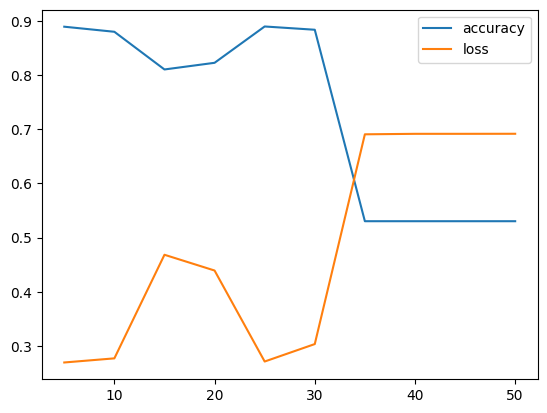

In [45]:
import matplotlib.pyplot as plt

results = []
for model in models:
    loss, accuracy = model['model'].evaluate(finalXtest, Ytest, batch_size = 100)
    results.append([accuracy, loss])

y1 = [i[0] for i in results]
y2 = [i[1] for i in results]

plt.plot([model['layer'] for model in models], y1, label="accuracy")
plt.plot([model['layer'] for model in models], y2, label="loss")
plt.legend()
plt.show()
